In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import io

In [5]:
data_o_vib = pd.read_csv("data/Musical training and Pitch perception - O -_ Vib (respuestas) - Respuestas de formulario 1.csv")
data_vib_o = pd.read_csv("data/Musical training and Pitch perception - Vib -_ O - Respuestas de formulario 1.csv")

total_data = pd.concat([data_o_vib, data_vib_o], ignore_index=True)

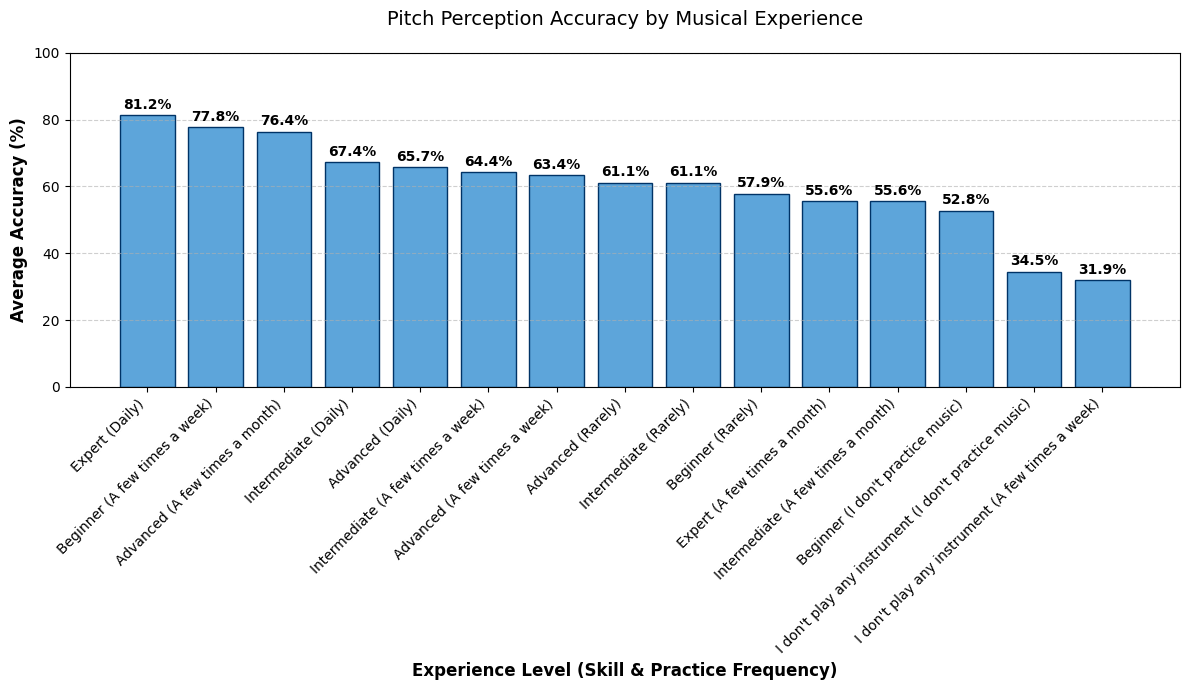

In [6]:
# 2. Identify the test columns (starting with (+) or (-))
# These represent the pitch change tests (Positive = Ascending, Negative = Descending)
test_cols = [c for c in total_data.columns if c.startswith("(+)") or c.startswith("(-)")]

# 3. Define the accuracy calculation function
def calculate_accuracy(row):
    correct = 0
    total = len(test_cols)
    for col in test_cols:
        # Determine ground truth from the column name
        # Note: Matching the spelling 'Acending' found in the dataset
        expected = "Acending" if col.startswith("(+)") else "Descending"
        if row[col] == expected:
            correct += 1
    return (correct / total) * 100

# Apply accuracy calculation to each participant
total_data['Accuracy'] = total_data.apply(calculate_accuracy, axis=1)

# 4. Create the composite grouping: Skill Level + Practice Frequency
skill_col = "How would you rate your skill on your primary instrument? "
practice_col = "If so, how often do you practice music?"
total_data['Group'] = total_data[skill_col].str.strip() + " (" + total_data[practice_col].str.strip() + ")"

# 5. Aggregate average accuracy by Group
grouped_data = total_data.groupby('Group')['Accuracy'].mean().sort_values(ascending=False).reset_index()

# 6. Plot the results
plt.figure(figsize=(12, 7))
bars = plt.bar(grouped_data['Group'], grouped_data['Accuracy'], color='#5da5da', edgecolor='#003366')

plt.xlabel('Experience Level (Skill & Practice Frequency)', fontsize=12, fontweight='bold')
plt.ylabel('Average Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Pitch Perception Accuracy by Musical Experience', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add percentage labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('accuracy_by_experience.png')
plt.show()